#  Simulated Daily Activity Dataset from Smartwatch Sensors

This synthetic dataset simulates daily motion signals collected from **1000 individuals** wearing a smartwatch over a **30-day** period.

###  How it was generated:
- Each individual is randomly assigned to one of **6 activity profiles**:
  - 0 = Sedentary
  - 1 = Normal walking
  - 2 = Brisk walking
  - 3 = Jogging
  - 4 = Irregular movement
  - 5 = Abnormal sensor behavior
- Each activity label has a **unique set of 3 underlying sine functions** representing its movement dynamics.
- Each person's daily signal is a **random weighted mix of their label's sine waves**, with added Gaussian noise to simulate real-world variability.


###  Purpose:
- Train a 1D-CNN to classify activity profiles using raw temporal data
- Ensure label consistency through shared signal structure across people

---

This dataset is well-suited for teaching CNNs on time-series signals with known label structure.


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


In [ ]:
#unzip file
file_path="/content/human+activity+recognition+using+smartphones.zip"


In [ ]:
# Set random seed
np.random.seed(42) #ensures enerated data is unifrom for  everyone

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
n_people = 1500
n_days = 30
timesteps_per_day = 128
n_labels = 6
n_latent_per_label = 3  # number of latent sine functions per class
total_samples = n_people * n_days

# Assign a label to each person uniformly
person_labels = np.random.choice(n_labels, size=n_people)
print("Label distribution (people):", dict(zip(*np.unique(person_labels, return_counts=True))))

# Time vector for a day
time = np.linspace(0, 2 * np.pi, timesteps_per_day)

# Generate latent signal templates per label
label_templates = {}
for label in range(n_labels):
    # e.g., 3 sine waves with slightly different frequencies
    label_templates[label] = np.array([np.sin((f + 1) * time + label) for f in range(n_latent_per_label)])

# Build data: shape (samples, timesteps)
X = []
y = []

for person_id in range(n_people):
    label = person_labels[person_id]
    template = label_templates[label]

    for _ in range(n_days):
        # Mix latent waves with random weights and small noise
        weights = np.random.randn(n_latent_per_label)
        signal = weights @ template + 0.1 * np.random.randn(timesteps_per_day)
        X.append(signal)
        y.append(label)

X = np.stack(X)  # shape: (500 × 30, 128)
y = np.array(y)  # shape: (500 × 30,)

print("Final shape of X:", X.shape)  # (15000, 128)
print("Final shape of y:", y.shape)
print("Class distribution:", dict(zip(*np.unique(y, return_counts=True))))


Label distribution (people): {np.int64(0): np.int64(266), np.int64(1): np.int64(242), np.int64(2): np.int64(243), np.int64(3): np.int64(248), np.int64(4): np.int64(253), np.int64(5): np.int64(248)}
Final shape of X: (45000, 128)
Final shape of y: (45000,)
Class distribution: {np.int64(0): np.int64(7980), np.int64(1): np.int64(7260), np.int64(2): np.int64(7290), np.int64(3): np.int64(7440), np.int64(4): np.int64(7590), np.int64(5): np.int64(7440)}


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Visualize Raw Sensor Data
We visualize a few sensor channels to understand the structure and noise.

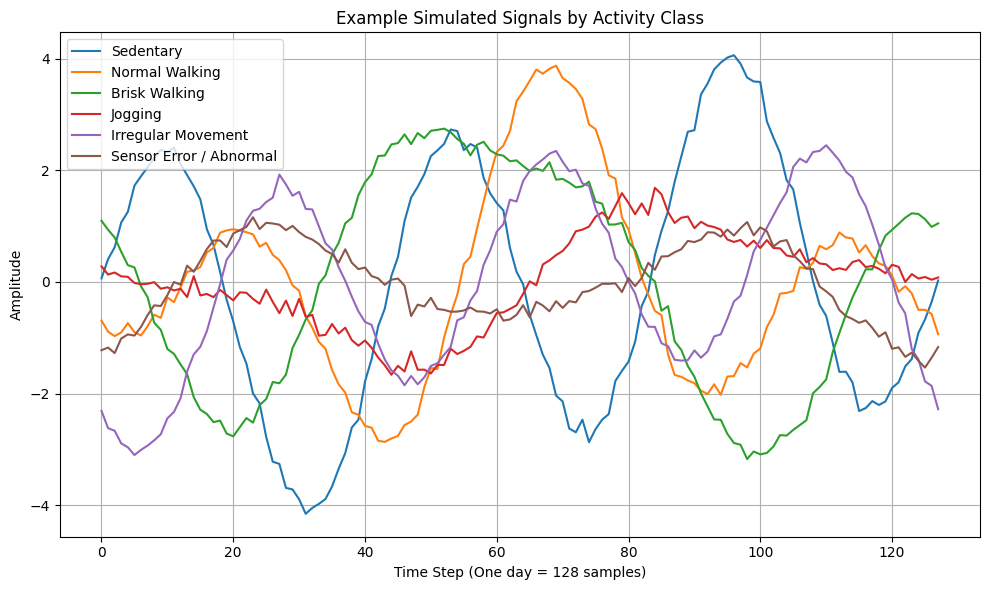

In [ ]:
# Define descriptive names for each activity label
activity_names = {
    0: "Sedentary",
    1: "Normal Walking",
    2: "Brisk Walking",
    3: "Jogging",
    4: "Irregular Movement",
    5: "Sensor Error / Abnormal"
}

# Create a figure with appropriate size
plt.figure(figsize=(10, 6
                    ))

# Loop through each label and plot one sample for each
for label in range(n_labels):
    # Find the first index where this label appears
    sample_idx = np.where(y == label)[0][0]

    # Extract the corresponding signal (a single 128-length time window)
    signal = X[sample_idx]

    # Plot the signal with a descriptive label
    plt.plot(signal, label=activity_names[label])

# Set plot title and axis labels
plt.title("Example Simulated Signals by Activity Class")
plt.xlabel("Time Step (One day = 128 samples)")
plt.ylabel("Amplitude")

# Display legend with activity names
plt.legend()

# Improve spacing and layout
plt.grid(True)
plt.tight_layout()

# Display the plot
plt.show()


# Prepare PyTorch Dataset and DataLoader

In [ ]:

# Define PyTorch dataset
class SignalDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X[:, np.newaxis, :], dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
train_ds = SignalDataset(X_train, y_train)
test_ds = SignalDataset(X_test, y_test)
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=64)


# Define a simple 1D-CNN Model

In [ ]:
# Simple 1D CNN model
class Simple1DCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm1d(16)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(32)
        self.pool = nn.AdaptiveMaxPool1d(1) #
        self.fc = nn.Linear(32, n_labels)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))   # (B, 16, 128)
        x = F.relu(self.bn2(self.conv2(x)))   # (B, 32, 128)
        x = self.pool(x).squeeze(-1)          # (B, 32) #squeeze(-1) flattens the data
        return self.fc(x)

model = Simple1DCNN().to(device)  # move model to device


# Train the Model

In [ ]:
def train_model(model, train_dl, test_dl, epochs=20):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    train_loss = []
    test_acc = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for xb, yb in train_dl:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for xb, yb in test_dl:
                xb, yb = xb.to(device), yb.to(device)
                preds = model(xb)
                correct += (preds.argmax(1) == yb).sum().item()
                total += yb.size(0)

        acc = correct / total
        train_loss.append(total_loss / len(train_dl))
        test_acc.append(acc)
        print(f"Epoch {epoch+1}: Loss = {train_loss[-1]:.4f}, Test Acc = {acc:.4f}")

    return train_loss, test_acc

train_loss, test_acc = train_model(model, train_dl, test_dl)


Epoch 1: Loss = 1.3173, Test Acc = 0.5714
Epoch 2: Loss = 0.9473, Test Acc = 0.5886
Epoch 3: Loss = 0.8539, Test Acc = 0.6699
Epoch 4: Loss = 0.8072, Test Acc = 0.6786
Epoch 5: Loss = 0.7802, Test Acc = 0.6941
Epoch 6: Loss = 0.7548, Test Acc = 0.6888
Epoch 7: Loss = 0.7330, Test Acc = 0.6970
Epoch 8: Loss = 0.7191, Test Acc = 0.7073
Epoch 9: Loss = 0.7023, Test Acc = 0.7186
Epoch 10: Loss = 0.6903, Test Acc = 0.7006
Epoch 11: Loss = 0.6769, Test Acc = 0.7143
Epoch 12: Loss = 0.6689, Test Acc = 0.7078
Epoch 13: Loss = 0.6594, Test Acc = 0.7087
Epoch 14: Loss = 0.6493, Test Acc = 0.7254
Epoch 15: Loss = 0.6421, Test Acc = 0.7179
Epoch 16: Loss = 0.6362, Test Acc = 0.7306
Epoch 17: Loss = 0.6311, Test Acc = 0.7213
Epoch 18: Loss = 0.6213, Test Acc = 0.7278
Epoch 19: Loss = 0.6178, Test Acc = 0.7272
Epoch 20: Loss = 0.6117, Test Acc = 0.7432


# TRAINING CURVE VISUALIZATION


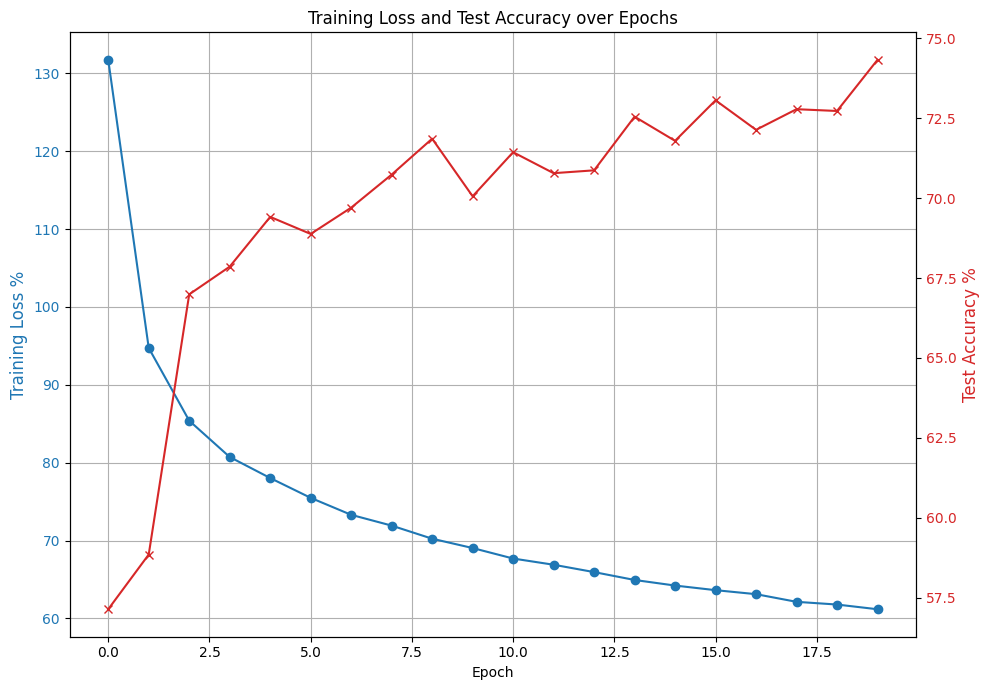

In [ ]:
# Plot loss and accuracy on the same figure using dual y-axes
fig, ax1 = plt.subplots(figsize=(10, 7))

# Left y-axis for training loss
color = 'tab:blue'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Training Loss %', color=color, fontsize=12)
ax1.plot([loss * 100 for loss in train_loss], color=color, marker='o', label='Training Loss')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True)

# Right y-axis for test accuracy
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Test Accuracy %', color=color, fontsize=12)
ax2.plot([acc * 100 for acc in test_acc], color=color, marker='x', label='Test Accuracy')
ax2.tick_params(axis='y', labelcolor=color)

# Title and layout
plt.title('Training Loss and Test Accuracy over Epochs')
fig.tight_layout()
plt.show()


# Evaluate the Model

              precision    recall  f1-score   support

           0       0.74      0.93      0.82      1596
           1       0.75      0.58      0.65      1452
           2       0.71      0.71      0.71      1458
           3       0.83      0.76      0.80      1488
           4       0.69      0.77      0.73      1518
           5       0.75      0.69      0.72      1488

    accuracy                           0.74      9000
   macro avg       0.75      0.74      0.74      9000
weighted avg       0.75      0.74      0.74      9000



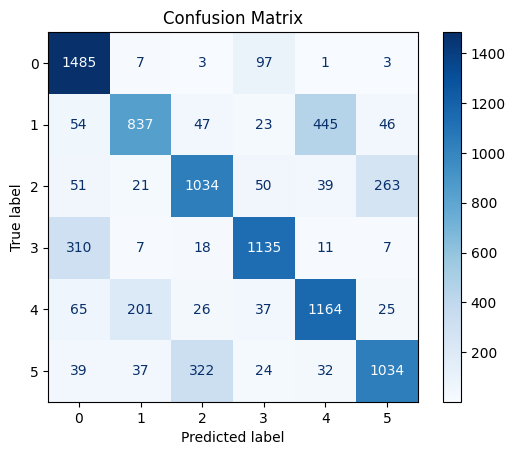

In [ ]:
y_true, y_pred = [], []
model.eval()
with torch.no_grad():
    for xb, yb in test_dl:
        xb = xb.to(device)
        preds = model(xb).cpu()
        y_true.extend(yb.numpy())
        y_pred.extend(preds.argmax(1).numpy())

print(classification_report(y_true, y_pred))
cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm).plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


## Human Activity Dataset

In [ ]:
import zipfile
import os

# Get the file path from the variable
file_path = "/content/human+activity+recognition+using+smartphones.zip"

# Define the directory to extract to
extract_dir = "/content/human_activity_data"

# Create the extraction directory if it doesn't exist
os.makedirs(extract_dir, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"File extracted to: {extract_dir}")

uci_path = "/content/human_activity_data/UCI HAR Dataset.zip"
uci_exrtact_dir = "/content/uci_data"
os.makedirs(uci_exrtact_dir, exist_ok=True)
with zipfile.ZipFile(uci_path, 'r') as zip_ref:
    zip_ref.extractall(uci_exrtact_dir)

print(f"File extracted to: {uci_exrtact_dir}")

File extracted to: /content/human_activity_data
File extracted to: /content/uci_data


In [ ]:
# prompt: stack files in this dirextory /content/uci_data/UCI HAR Dataset/test/Inertial Signals name it test_stacked

import numpy as np
import glob

test_files = glob.glob('/content/uci_data/UCI HAR Dataset/test/Inertial Signals/*')

# Read each file and stack
test_stacked = []
for file_path in test_files:
    data = np.loadtxt(file_path)
    test_stacked.append(data)

# Convert list of arrays to a single numpy array
test_stacked = np.stack(test_stacked, axis=0)

print(f"Stacked test data shape: {test_stacked.shape}")

Stacked test data shape: (9, 2947, 128)


In [ ]:
# prompt: do the same for this, call it train_stacked /content/uci_data/UCI HAR Dataset/train/Inertial Signals

import numpy as np
# Assuming 'train_stacked' is for the training data
train_files = glob.glob('/content/uci_data/UCI HAR Dataset/train/Inertial Signals/*')

# Read each file and stack
train_stacked = []
for file_path in train_files:
    data = np.loadtxt(file_path)
    train_stacked.append(data)

# Convert list of arrays to a single numpy array
train_stacked = np.stack(train_stacked, axis=0)

print(f"Stacked train data shape: {train_stacked.shape}")

Stacked train data shape: (9, 7352, 128)


In [ ]:
# prompt: view stacked files

# Example of how to access and print the stacked data
print("\nPrinting a small portion of the stacked test data:")
print(test_stacked[:, :, :5])  # Print first 5 time steps for all files in test set

print("\nPrinting a small portion of the stacked train data:")
print(train_stacked[:, :, :5]) # Print first 5 time steps for all files in train set

# You can now use train_stacked and test_stacked for further processing.
# For instance, if you want to see the data from a specific file (e.g., the first file loaded in the list):
# print("\nData from the first file loaded in test set:")
# print(test_stacked[0])

# If you want to see data from the first file and first channel:
# print("\nData from the first file and first channel in test set:")
# print(test_stacked[0, 0, :])


Printing a small portion of the stacked test data:
[[[ 0.4374637   0.4682641   0.4982574   0.4793957   0.3898935 ]
  [ 0.1702878   0.1752221   0.1308618   0.07885598  0.08249604]
  [-0.0387265  -0.04728239 -0.05390624 -0.05946352 -0.06384749]
  ...
  [ 0.8457912   0.8385992   0.8132189   0.8194174   0.8243028 ]
  [-0.8444065  -0.6438182  -0.5957706  -0.3860118  -0.2319838 ]
  [-0.3324763  -0.3165543  -0.5837689  -0.7698534  -0.8245034 ]]

 [[ 0.01165315  0.01310909  0.01126885  0.02783073  0.00231835]
  [ 0.00927963  0.00492971  0.0039536   0.00921443  0.01615613]
  [ 0.00573194  0.00706565  0.00510976  0.00243396  0.00202394]
  ...
  [-0.1476465  -0.1699026  -0.168698   -0.1385999  -0.1447809 ]
  [ 0.07122683 -0.0886653  -0.07067473 -0.1168874  -0.2141171 ]
  [-0.1936425  -0.06498738 -0.0971221  -0.05573479  0.04110147]]

 [[ 1.041216    1.041803    1.039086    1.054768    1.028376  ]
  [ 0.9991921   0.9946787   0.9935518   0.9986743   1.00549   ]
  [ 0.9975931   0.9989703   0.997057

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

# Load labels
y_train = np.loadtxt('/content/uci_data/UCI HAR Dataset/train/y_train.txt')
y_test = np.loadtxt('/content/uci_data/UCI HAR Dataset/test/y_test.txt')

# Optional: Convert to 0-indexed if necessary (since labels are 1-6)
y_train -= 1
y_test -= 1

class HAR_Dataset(Dataset):
    def __init__(self, X, y):
        # X is expected to be (samples, channels, timesteps)
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)


    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Use the stacked inertial signals with the correct shape (samples, channels, timesteps)
train_dataset = HAR_Dataset(X_train_signals, y_train)
test_dataset = HAR_Dataset(X_test_signals, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
# Look at one example directly from the dataset
X_sample, y_sample = train_dataset[0]
print("Single sample X shape:", X_sample.shape)  # (128, 9)
print("Label:", y_sample.item())
print("Signal data (first channel):\n", X_sample[:, 0])


Single sample X shape: torch.Size([7352, 128])
Label: 4
Signal data (first channel):
 tensor([-0.1232, -0.1240, -0.1200,  ..., -0.1712, -0.2238, -0.3061])


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class HAR1DCNN(nn.Module):
    def __init__(self, num_classes=6):  # HAR dataset has 6 activity classes
        super(HAR1DCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=9, out_channels=32, kernel_size=3)
        self.bn1 = nn.BatchNorm1d(32)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(64)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(64, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))   # [batch, 32, seq_len-2]
        x = F.relu(self.bn2(self.conv2(x)))   # [batch, 64, seq_len-4]
        x = self.pool(x).squeeze(-1)          # [batch, 64]
        x = self.fc(x)                        # [batch, num_classes]
        return x

In [ ]:
# Instantiate model
model = HAR1DCNN(num_classes=6)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [ ]:
#Training loop
for epoch in range(10):
    model.train()
    for X_batch, y_batch in train_loader:
        # X_batch is already in the shape [batch, channels=9, time=128] from the DataLoader
        # X_batch = X_batch.permute(0, 2, 1)  # Remove this line
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same